In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')
import pickle
import joblib

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. DATA LOADING
print("="*50)
print("1. DATA LOADING")
print("="*50)

# Load the data
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Project/customer-churn-case.csv')
print(f"Dataset shape: {df.shape}")
print(f"Cloumns: {df.columns.tolist()}")

1. DATA LOADING
Dataset shape: (69999, 172)
Cloumns: ['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 

In [ ]:
# 2. DATA CLEANING
print("\n" + "="*50)
print("2. DATA CLEANING")
print("="*50)

# Check for missing values
print("Missing values per column:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])


2. DATA CLEANING
Missing values per column:
loc_og_t2o_mou            702
std_og_t2o_mou            702
loc_ic_t2o_mou            702
last_date_of_month_7      399
last_date_of_month_8      733
                        ...  
night_pck_user_7        52134
night_pck_user_8        51582
fb_user_6               52431
fb_user_7               52134
fb_user_8               51582
Length: 125, dtype: int64


In [ ]:
# Handle missing values
df_clean = df.copy()

# Fill numeric columns with median
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numeric_cols] = df_clean[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Fill categorical columns with mode
categorical_cols = df_clean.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0] if not df_clean[col].mode().empty else 'Unknown')

In [ ]:
# 3. DATA PREPROCESSING
print("\n" + "="*50)
print("3. DATA PREPROCESSING")
print("="*50)

df_processed = df_clean.copy()

# Convert date columns to datetime and extract features
date_columns = [col for col in df_processed.columns if 'date' in col.lower()]
print(f"Date columns found: {date_columns}")

for col in date_columns:
    df_processed[col] = pd.to_datetime(df_processed[col], errors='coerce')
    df_processed[f'{col}_day'] = df_processed[col].dt.day
    df_processed[f'{col}_month'] = df_processed[col].dt.month
    df_processed[f'{col}_year'] = df_processed[col].dt.year

# Drop original date columns
df_processed = df_processed.drop(date_columns, axis=1)

# Handle categorical variables
categorical_cols = df_processed.select_dtypes(include=['object']).columns
print(f"Categorical columns: {categorical_cols.tolist()}")

le = LabelEncoder()
for col in categorical_cols:
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))

print(f"Processed dataset shape: {df_processed.shape}")


3. DATA PREPROCESSING
Date columns found: ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']
Categorical columns: []
Processed dataset shape: (69999, 190)


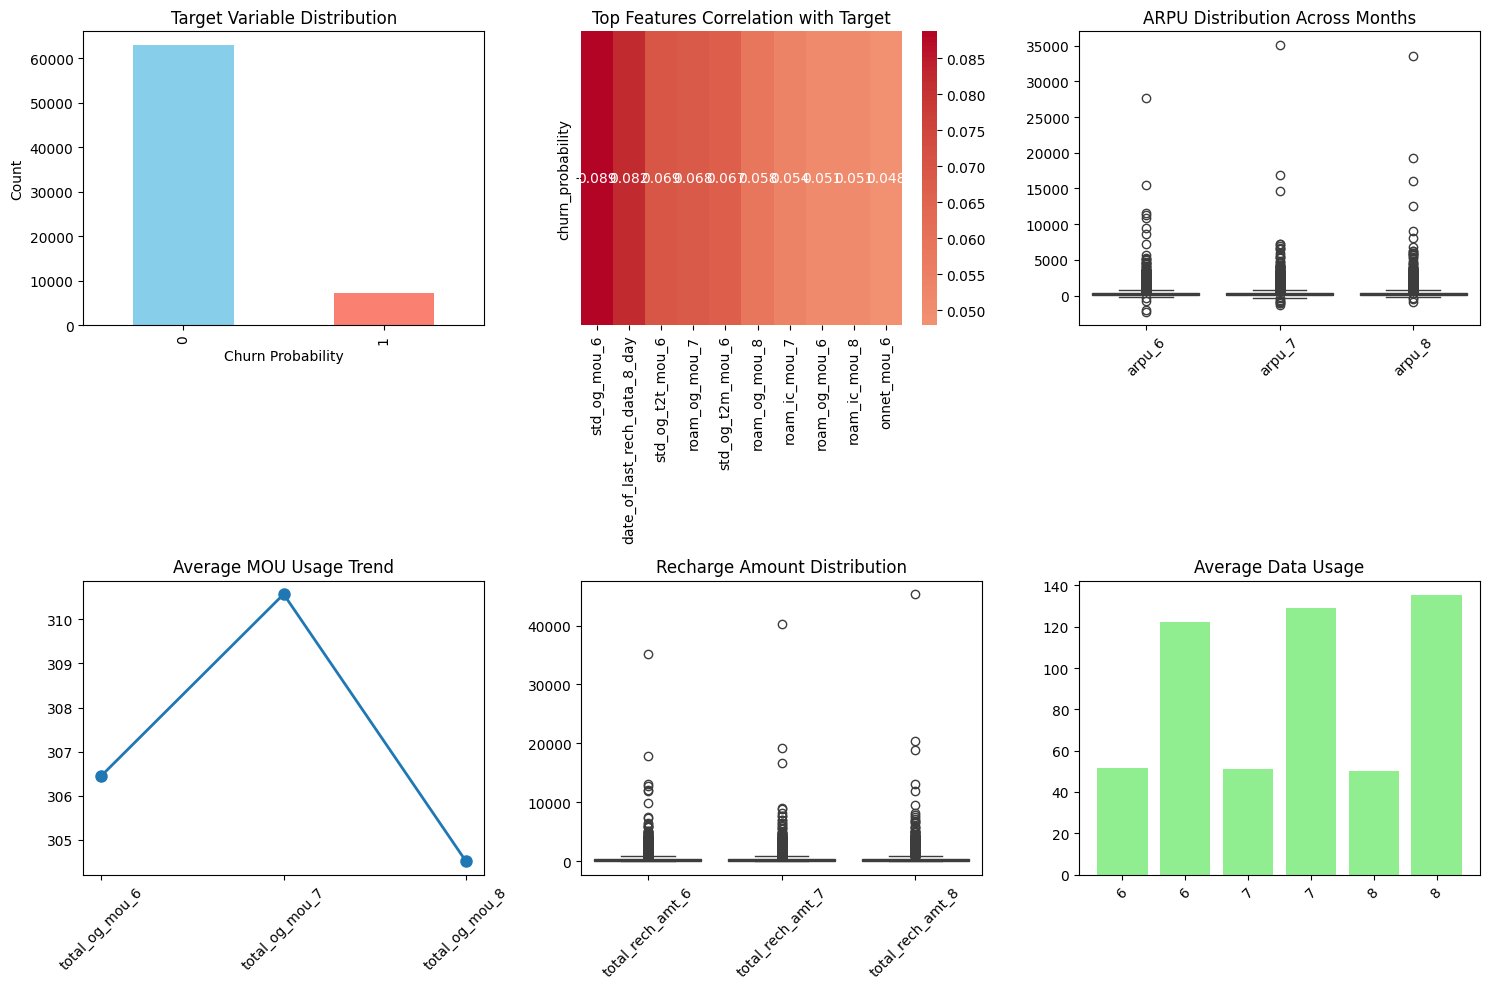

In [ ]:
# Target variable analysis
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
df_clean['churn_probability'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Variable Distribution')
plt.xlabel('Churn Probability')
plt.ylabel('Count')

# Correlation heatmap
plt.subplot(2, 3, 2)
numeric_df = df_processed.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
target_corr = correlation_matrix['churn_probability'].sort_values(ascending=False)
top_corr_features = target_corr[1:11]  # Exclude target itself
sns.heatmap(pd.DataFrame(top_corr_features).T, annot=True, cmap='coolwarm', center=0)
plt.title('Top Features Correlation with Target')

# ARPU distribution
plt.subplot(2, 3, 3)
sns.boxplot(data=df_clean[['arpu_6', 'arpu_7', 'arpu_8']])
plt.title('ARPU Distribution Across Months')
plt.xticks(rotation=45)

# MOU usage trends
plt.subplot(2, 3, 4)
mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
mou_data = df_clean[mou_cols].mean()
plt.plot(mou_data.index, mou_data.values, marker='o', linewidth=2, markersize=8)
plt.title('Average MOU Usage Trend')
plt.xticks(rotation=45)

# Recharge amount distribution
plt.subplot(2, 3, 5)
sns.boxplot(data=df_clean[['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8']])
plt.title('Recharge Amount Distribution')
plt.xticks(rotation=45)

# Data usage distribution
plt.subplot(2, 3, 6)
data_cols = ['vol_2g_mb_6', 'vol_3g_mb_6', 'vol_2g_mb_7', 'vol_3g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_8']
if all(col in df_clean.columns for col in data_cols):
    data_usage = df_clean[data_cols].mean()
    plt.bar(range(len(data_usage)), data_usage.values, color='lightgreen')
    plt.xticks(range(len(data_usage)), [col.split('_')[-1] for col in data_usage.index], rotation=45)
    plt.title('Average Data Usage')

plt.tight_layout()
plt.show()

In [ ]:
# 5. FEATURE ENGINEERING
print("\n" + "="*50)
print("5. FEATURE ENGINEERING")
print("="*50)

df_features = df_processed.copy()

# Create trend features
def calculate_trend(row, base_col, months=['6', '7', '8']):
    values = [row[f'{base_col}_{month}'] for month in months if f'{base_col}_{month}' in row]
    if len(values) > 1:
        return np.polyfit(range(len(values)), values, 1)[0]  # Slope of trend
    return 0

# Revenue trends
df_features['arpu_trend'] = df_features.apply(lambda x: calculate_trend(x, 'arpu'), axis=1)
df_features['total_rech_amt_trend'] = df_features.apply(lambda x: calculate_trend(x, 'total_rech_amt'), axis=1)

# Usage trends
df_features['total_og_mou_trend'] = df_features.apply(lambda x: calculate_trend(x, 'total_og_mou'), axis=1)
df_features['total_ic_mou_trend'] = df_features.apply(lambda x: calculate_trend(x, 'total_ic_mou'), axis=1)

# Data usage trends
if all(col in df_features.columns for col in ['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8']):
    df_features['vol_2g_trend'] = df_features.apply(lambda x: calculate_trend(x, 'vol_2g_mb'), axis=1)
if all(col in df_features.columns for col in ['vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8']):
    df_features['vol_3g_trend'] = df_features.apply(lambda x: calculate_trend(x, 'vol_3g_mb'), axis=1)

# Create ratio features
df_features['arpu_8_to_6_ratio'] = df_features['arpu_8'] / (df_features['arpu_6'] + 1e-5)
df_features['rech_amt_8_to_6_ratio'] = df_features['total_rech_amt_8'] / (df_features['total_rech_amt_6'] + 1e-5)
df_features['mou_8_to_6_ratio'] = df_features['total_og_mou_8'] / (df_features['total_og_mou_6'] + 1e-5)

# Create usage variability features
for feature_type in ['arpu', 'total_og_mou', 'total_rech_amt']:
    cols = [f'{feature_type}_{month}' for month in ['6', '7', '8'] if f'{feature_type}_{month}' in df_features.columns]
    if len(cols) > 1:
        df_features[f'{feature_type}_cv'] = df_features[cols].std(axis=1) / (df_features[cols].mean(axis=1) + 1e-5)

print(f"After feature engineering - Shape: {df_features.shape}")
print(f"New features created: {[col for col in df_features.columns if col not in df_processed.columns]}")


5. FEATURE ENGINEERING
After feature engineering - Shape: (69999, 202)
New features created: ['arpu_trend', 'total_rech_amt_trend', 'total_og_mou_trend', 'total_ic_mou_trend', 'vol_2g_trend', 'vol_3g_trend', 'arpu_8_to_6_ratio', 'rech_amt_8_to_6_ratio', 'mou_8_to_6_ratio', 'arpu_cv', 'total_og_mou_cv', 'total_rech_amt_cv']


In [ ]:
# 6. DATA SPLITTING
print("\n" + "="*50)
print("7. DATA SPLITTING")
print("="*50)

X = df_features.drop('churn_probability', axis=1)
y = df_features['churn_probability']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Churn distribution in training: {y_train.value_counts().to_dict()}")
print(f"Churn distribution in test: {y_test.value_counts().to_dict()}")


7. DATA SPLITTING
Training set: (55999, 201)
Test set: (14000, 201)
Churn distribution in training: {0: 50293, 1: 5706}
Churn distribution in test: {0: 12574, 1: 1426}


In [ ]:
# 7. STANDARDIZATION
print("\n" + "="*50)
print("8. STANDARDIZATION")
print("="*50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Standardization completed")

# 8. SMOTE FOR IMBALANCED DATA
print("\n" + "="*50)
print("9. SMOTE PROCESSING")
print("="*50)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Before SMOTE: {X_train_scaled.shape}, {y_train.value_counts().to_dict()}")
print(f"After SMOTE: {X_train_smote.shape}, {pd.Series(y_train_smote).value_counts().to_dict()}")


8. STANDARDIZATION
Standardization completed

9. SMOTE PROCESSING
Before SMOTE: (55999, 201), {0: 50293, 1: 5706}
After SMOTE: (100586, 201), {0: 50293, 1: 50293}


In [ ]:
#  10. MODEL BUILDING - GRIDSEARCHCV WITH K-FOLD
# print("\n" + "="*50)
# print("10. MODEL BUILDING - GRIDSEARCHCV")
# print("="*50)

# # Define models and parameters for GridSearchCV
# models = {
#     'RandomForest': {
#         'model': RandomForestClassifier(random_state=42),
#         'params': {
#             'n_estimators': [100, 200],
#             'max_depth': [10, 20, 30],
#             'min_samples_split': [2, 5],
#             'min_samples_leaf': [1, 2]
#         }
#     },
#     'LogisticRegression': {
#         'model': LogisticRegression(random_state=42),
#         'params': {
#             'penalty': ['l2', 'l1'],
#         }
#     }
# }

# # Perform GridSearchCV
# best_models = {}
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for name, config in models.items():
#     print(f"\nTraining {name}...")
#     grid_search = GridSearchCV(
#         config['model'],
#         config['params'],
#         cv=cv,
#         scoring='f1',
#         n_jobs=-1,
#         verbose=1
#     )

#     grid_search.fit(X_train_smote, y_train_smote)
#     best_models[name] = grid_search.best_estimator_
#     print(f"Best parameters for {name}: {grid_search.best_params_}")
#     print(f"Best CV score for {name}: {grid_search.best_score_:.4f}")

In [ ]:
# 10. MODEL BUILDING - GRIDSEARCHCV WITH K-FOLD
print("\n" + "="*50)
print("10. MODEL BUILDING - GRIDSEARCHCV")
print("="*50)

# Define models and parameters for GridSearchCV
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100],
            'max_depth': [10],
            'min_samples_split': [2],
            'min_samples_leaf': [1]
        }
    }
}

# Perform GridSearchCV
best_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, config in models.items():
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_smote, y_train_smote)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best CV score for {name}: {grid_search.best_score_:.4f}")


10. MODEL BUILDING - GRIDSEARCHCV

Training RandomForest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for RandomForest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score for RandomForest: 0.9284


In [ ]:
# 11. MODEL BUILDING - RANDOMIZEDSEARCHCV WITH K-FOLD
print("\n" + "="*50)
print("11. MODEL BUILDING - RANDOMIZEDSEARCHCV")
print("="*50)

# Define models for RandomizedSearchCV
random_models = {
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    }
}

# Perform RandomizedSearchCV
for name, config in random_models.items():
    print(f"\nTraining {name} with RandomizedSearchCV...")
    random_search = RandomizedSearchCV(
        config['model'],
        config['params'],
        n_iter=10,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    random_search.fit(X_train_smote, y_train_smote)
    best_models[name] = random_search.best_estimator_
    print(f"Best parameters for {name}: {random_search.best_params_}")
    print(f"Best CV score for {name}: {random_search.best_score_:.4f}")


11. MODEL BUILDING - RANDOMIZEDSEARCHCV

Training GradientBoosting with RandomizedSearchCV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
# 12. MODEL EVALUATION AND BEST MODEL SELECTION
print("\n" + "="*50)
print("12. MODEL EVALUATION")
print("="*50)

# Evaluate all models
results = {}
for name, model in best_models.items():
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': auc,
        'model': model
    }

    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))

# Select best model based on F1-score
best_model_name = max(results.keys(), key=lambda x: results[x]['f1_score'])
best_model = results[best_model_name]['model']
print(f"\n*** BEST MODEL: {best_model_name} ***")
print(f"Best F1-Score: {results[best_model_name]['f1_score']:.4f}")

# Plot confusion matrix for best model
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot ROC curve
plt.subplot(1, 3, 2)
for name, result in results.items():
    y_pred_proba = result['model'].predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

# Feature importance for tree-based models
plt.subplot(1, 3, 3)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title('Top 10 Feature Importance')
    plt.xlabel('Importance')

plt.tight_layout()
plt.show()


In [ ]:
print("\n" + "="*50)
print("13. SAVING MODEL")
print("="*50)

# Save the best model
model_filename = f'best_churn_model_{best_model_name}.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)